In [1]:
# SPDX-License-Identifier: (GPL-2.0+) 

import csv
import show_graphs as sg

In [2]:
trade_data = csv.DictReader(open('data/cow/Dyadic_COW_4.0_shortened.csv', 'r'))
trade_data = list(trade_data)
dispute_data = csv.DictReader(open('data/mid/MIDB_5.0.csv', 'r'))
dispute_data = list(dispute_data)

In [5]:
conflict_num = input("Enter a conflict number.  Type \"exit\" without the quotes to leave\n")
try:
    conflict_num = int(conflict_num)
except ValueError:
    print("Invalid conflict number")
    exit(0)

print("Parsing conflict number.")
instigatorsA, instigatorsB, sideA, sideB, start_year = sg.parse_conflict_num(dispute_data, conflict_num)

if int(start_year) == -1:
    print("Conflict number {0} does not exist".format(str(conflict_num)))
    exit(0)

print("Retrieving trade partners")
instigatorsA_trade_partners, instigatorsB_trade_partners = sg.get_conflict_trade_partners(
    trade_data,
    instigatorsA, 
    instigatorsB, 
    start_year
)
instigatorsA_trade_partners_unknown, instigatorsB_trade_partners_unknown = sg.get_conflict_trade_partners(
        trade_data,
        instigatorsA,
        instigatorsB,
        start_year,
    ignore_unknown=False
)

print("Parsing trade data for side A")
trade_valuesA = sg.parse_trade_data(trade_data, instigatorsA_trade_partners, start_year) if len(instigatorsA_trade_partners) > 1 else None
trade_valuesA_unknown = sg.parse_trade_data(trade_data, instigatorsA_trade_partners_unknown, start_year, ignore_unknown = False) if len(instigatorsA_trade_partners_unknown) > 1 else None

print("Parsing trade data for side B")
trade_valuesB = sg.parse_trade_data(trade_data, instigatorsB_trade_partners, start_year) if len(instigatorsB_trade_partners) > 1 else None
trade_valuesB_unknown = sg.parse_trade_data(trade_data, instigatorsB_trade_partners_unknown, start_year, ignore_unknown = False) if len(instigatorsB_trade_partners_unknown) > 1 else None

print("Calculating trade percentages for side A")
trade_percentagesA = sg.calculate_trade_percentages(trade_valuesA) if trade_valuesA is not None else None

print("Calculating trade percentages for side B")
trade_percentagesB = sg.calculate_trade_percentages(trade_valuesB) if trade_valuesB is not None else None

if trade_valuesA_unknown != None:
    G_A, color_map_A = sg.create_trade_war_graphs(instigatorsA, sideA, trade_valuesA_unknown, 'A')
else:
    G_A = None
    color_map_A = None
if trade_valuesB_unknown != None: 
    G_B, color_map_B = sg.create_trade_war_graphs(instigatorsB, sideB, trade_valuesB_unknown, 'B')
else:
    G_B = None
    color_map_B = None

Enter a conflict number.  Type "exit" without the quotes to leave
611
Parsing conflict number.
Retrieving trade partners
Parsing trade data for side A
Parsing trade data for side B
Calculating trade percentages for side A
Calculating trade percentages for side B


In [6]:
# Show Summaries
print("Side A Summary:")
sg.show_summary(trade_percentagesA, sideA, instigatorsA)
print("Side B Summary:")
sg.show_summary(trade_percentagesB, sideB, instigatorsB)


Side A Summary:
Instigators: ['USA']
Combatants: ['THI', 'ROK', 'PHI', 'AUL', 'NEW', 'USA', 'RVN', 'CAM']
Linear Regression: y = 0.16277055959305903x + 0.0274597478370846
Logistic Regression: y = 1/(1+e^-(0.0274597478370846 + 0.3447467402462808x))
Side B Summary:
Instigators: ['DRV']
Combatants: ['CHN', 'USR', 'DRV']
Linear Regression: y = 0.0x + 0.0
Logistic Regression model not available


In [9]:
# Eigenvector Centrality
A_eigen = sg.calculate_eigenvector_centrality(G_A)
B_eigen = sg.calculate_eigenvector_centrality(G_B)
print("Side A")
for country, centrality in A_eigen.items():
    print(country + ": \t" + str(centrality))
print("Side B")
for country, centrality in B_eigen.items():
    print(country + ": \t" + str(centrality))

Side A
USA: 	0.09205746178983228
CAN: 	0.09205746178983228
HAI: 	0.09205746178983228
DOM: 	0.09205746178983228
JAM: 	0.09205746178983228
TRI: 	0.09205746178983228
BAR: 	0.09205746178983228
MEX: 	0.09205746178983228
GUA: 	0.09205746178983228
HON: 	0.09205746178983228
SAL: 	0.09205746178983228
NIC: 	0.09205746178983228
COS: 	0.09205746178983228
PAN: 	0.09205746178983228
COL: 	0.09205746178983228
VEN: 	0.09205746178983228
GUY: 	0.09205746178983228
ECU: 	0.09205746178983228
PER: 	0.09205746178983228
BRA: 	0.09205746178983228
BOL: 	0.09205746178983228
PAR: 	0.09205746178983228
CHL: 	0.09205746178983228
ARG: 	0.09205746178983228
URU: 	0.09205746178983228
UKG: 	0.09205746178983228
IRE: 	0.09205746178983228
NTH: 	0.09205746178983228
BEL: 	0.09205746178983228
LUX: 	0.09205746178983228
FRN: 	0.09205746178983228
SWZ: 	0.09205746178983228
SPN: 	0.09205746178983228
POR: 	0.09205746178983228
GFR: 	0.09205746178983228
GDR: 	0.09205746178983228
POL: 	0.09205746178983228
AUS: 	0.09205746178983228
HUN: 

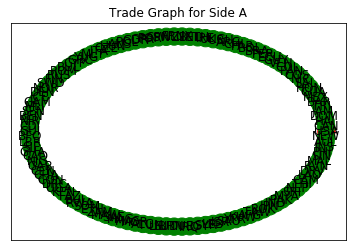

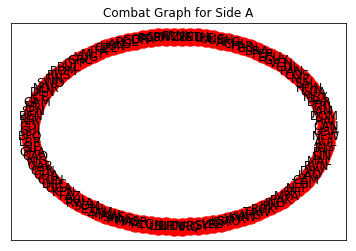

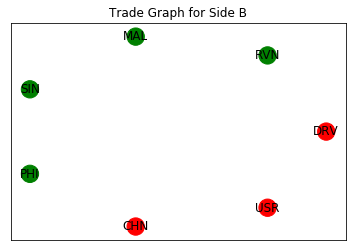

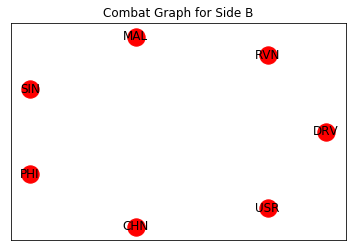

In [13]:
# Display Graphs
if G_A is not None:
    sg.render_graph(G_A, True, color_map_A, 'A')
    G_A = sg.remove_noncombatants(G_A, instigatorsA, sideA)
    sg.render_graph(G_A, False, 'r', 'A')
if G_B is not None:
    sg.render_graph(G_B, True, color_map_B, 'B')
    G_B = sg.remove_noncombatants(G_B, instigatorsB, sideB)
    sg.render_graph(G_B, False, 'r', 'B')